
# PyShop Session 4
***
##Advanced Topics in Statistics and Data Visualization

This session looks at some of the finer points of data manipulation in Pandas, some econometric methods available from StatModels, as well as how to fine tune your Matplotlib output.  In Pandas we will focus on data IO and data types, merge, grouping, reshaping, and time series.  In StatsModels we will look at some examples of OLS, discrete choice models, and plotting, but these will only be brief examples meant to introduce the library.  Finally, in Matplotlib we will look at the matplotlibrc file, discuss axes objects and object oriented plotting (including subplots), and a latex table output.  As with the previous session, these topics only scratch the surface, but should be enough to get you started.  By the end you should at least know where to look to find statistical methods for most economics applications, how to deal with data sets, and be familiar with the finer points of plotting in Python.

### Introduction

In order to ground this session in something more practical, we will focus on a real world econometric application.  In particular, we will download data from the PSID, manipulate that data, and study a simple regression (ok, maybe not real world for you, but real world for an undergrad!).  This session uses the PSIDPy package, which is a copy of PSIDr by Florian Oswald.

####Table of Contents
1.  Posting forms using requests
2.  Downloading a single PSID file
3.  Reading in the sas (hand waving!)  Just use PSIDpy
4.  Loading the fam_vars file and the ind_vars file
5.  Cleaning up the data a bit
6.  Merge, concatenate, join, groupby, etc.
7.  Indices, heirarchical indices, loc, idx, etc.  How to find data in your dataframe
8.  Descriptive statistics and plotting
9.  OLS with StatsModels
10.  Plotting with SeaBorn
11.  Adjusting your matplotlibrc file

### Posting Forms Using Requests

In order to access data on the PSID website, you need a few things.  First, you need a username and password.  Second, you need Requests.  And third, you need Beautiful Soup.

Anaconda should already contain both of these packages.  I'll assume you can figure out the user account yourself!

To read in the data from the SAS files, you'll need PSIDPy.  You can get it by running `pip install psid_py` from the command line.

<a href="http://docs.python-requests.org/en/latest/" target="_blank">Requests</a> is a package whose self proclaimed sub-title is "HTTP for Humans".  And it is just that!  HTTP is very difficult if you aren't a web guru and Requests makes it truly easy.

Let's look at how we can post a form to the PSID website using requests:

In [1]:
#Just to avoid problems later, import everything now
import zipfile
import tempfile
import os
import requests
import shutil
import getpass
#import seaborn.apionly
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from psid_py import read_sas
from io import BytesIO

%matplotlib inline

In [2]:
#First, define a username and password
#NOTE: Please don't abuse my account... I don't want to be barred from the PSID!
USERNAME = input("Please enter your PSID username: ")
PASSWORD = getpass.getpass("Please enter your PSID"
                                       + " password: ")

#USERNAME = "tyler.abbot@sciencespo.fr"
#PASSWORD = ""

#Create a requests session object, which will do all the HTTP for you
c = requests.Session()

#Define the URL of the login page
URL = 'http://simba.isr.umich.edu/u/login.aspx'

#Call the login page to "get" its raw HTML data
page = c.get(URL)

Please enter your PSID username: tyler.abbot@sciencespo.fr
Please enter your PSID password: ········


At this point, page is a requests object which contains the page data.  We can retrieve this html file using the `content` method, then scrape out the form variables we need.  But what variables DO we need?

1. Navigate to the PSID login page, right-click on the login window, and click "Inspect Element".  This will open a side bar showing the html and some other stuff.  

2. At the top, there will be several tabs; select the 'Network' tab.  

3. Now, click the 'Clear' button, right next to the red dot at the top.  

4. Now login.  At this point you'll see a bunch of things show up in the table.  

5. Find anything related to login.  For the PSID website this is 'Login.aspx'.  Click this and select the 'Headers' tab on the lower part of the side bar.

6. Now scroll down to the 'Form Data' section.

All of the variables listed here will be submitted to the form.  We are going to need to scrape the html for the values and submit them with our login information.

Here's how we'll scrape the page using Beautiful Soup:

In [3]:
soup = BeautifulSoup(page.content)
viewstate = soup.findAll("input", {"type": "hidden",
                         "name": "__VIEWSTATE"})
radscript = soup.findAll("input", {"type": "hidden",
                         "name": "RadScriptManager1_TSM"})
eventtarget = soup.findAll("input", {"type": "hidden",
                           "name": "__EVENTTARGET"})
eventargument = soup.findAll("input", {"type": "hidden",
                             "name": " __EVENTARGUMENT"})
viewstategenerator = soup.findAll("input", {"type": "hidden",
                                  "name": "__VIEWSTATEGENERATOR"})
eventvalidation = soup.findAll("input", {"type": "hidden",
                               "name": "__EVENTVALIDATION"})
radscript = soup.findAll("input", {"type": "hidden", "name":
                         "RadScriptManager1_TSM"})


In [4]:
print(viewstate)
print(eventtarget)

[<input id="__VIEWSTATE" name="__VIEWSTATE" type="hidden" value="vT4Hv482aiQV6WwOT/vBBhL6/ykS+qp37Up9y6ttw7xz8NsVKpAxOdbubH84+kjkrr6VNmX+B6Cnb80Mwd+KXlWfSCMOg+tYNUA1Eu3qda7st1vlb4zGQJpeDzsTLyea53NeFS21wgM28NKuybihDNyYnH/UcrMn9m+EwmgX1sVFGzeoYDCMrScbUu+3nd/mloCtGqhb5aGBCMVQUZSTtmwi2PFQ2WnfoBC1aORJIRYnnYFuanGPq4CRH+PONC0lQOh5sveWOH6dz1qfsbKQB4D4ZGXVETsNVkR0Ay6TvKwRIRON8OOXkta50HdcYBY1+BAKVeFv8snChk5CFRQjepj3xq7k0FqTp90NSMbRWEbnunA8e9N9qgxXjO7DbHhP8sIILXuA8i5yv4KB87kUUVlT/IkRq8hYYhITR6CR61I="/>]
[]


Notice that Beautiful soup Returns the entire html object associated with each variable.  This makes life so much easier.  So, now that you have your form variables, you want to pack them into a dictionary to pass to your Requests object.

In [5]:
#Gather form data into a single dictionary
params = {'RadScriptManager1_TSM': radscript[0]['value'],
          '__EVENTTARGET': '',
          ' __EVENTARGUMENT': '',
          '__VIEWSTATE': viewstate[0]['value'],
          '__VIEWSTATEGENERATOR': viewstategenerator[0]['value'],
          '__EVENTVALIDATION': eventvalidation[0]['value'],
          'ctl00$ContentPlaceHolder1$Login1$UserName': USERNAME,
          'ctl00$ContentPlaceHolder1$Login1$Password': PASSWORD,
          'ctl00$ContentPlaceHolder1$Login1$LoginButton': 'Log In',
          'ctl00_RadWindowManager1_ClientState': ''}


Now, we can post to the login page!

In [6]:
#Post the login form.  NOTE: Response code 200 implies OK
c.post('http://simba.isr.umich.edu/u/Login.aspx', data=params,
       headers={"Referer": "http://psidonline.isr.umich.edu/"})

<Response [200]>

Great, we're now logged into the PSID website.  Next, we need to download some data.  We are going to download a family file and an individual file, both for 1968, the first year the PSID was performed.  We'll also save this in a temporary directory, which we'll use until the end of this course and then delete, along with our wonderful data...

In [7]:
#Create a temporary directory to store unzipped files
#temp_dir = tempfile.mkdtemp() + os.sep

#File names in the psid are numbered
file = "1056"
url = 'http://simba.isr.umich.edu/Zips/GetFile.aspx?file=' + file
data1 = c.get(url, allow_redirects=False)

That's it!  We've successfully downloaded a zipped data file from the PSID website.  Since it would be nice to work on heirarchical indices, we are going to download data for another year, 1968.  Then, we'll unzip the files and extract the sas data to data-frames using the `psid_py` package:

In [8]:
#Download a second file
file = "1058"
url = 'http://simba.isr.umich.edu/Zips/GetFile.aspx?file=' + file
data2 = c.get(url, allow_redirects=False)

#Create a temporary directory to store unzipped files
temp_dir = tempfile.mkdtemp() + os.sep

x = pd.DataFrame()
y = pd.DataFrame()
frames = [x, y]

for i, data in enumerate([data1, data2]):
    #Extract the zipped files
    zipped = zipfile.ZipFile(BytesIO(data.content))
    files_to_unzip = (x for x in zipped.namelist() if 
                      any(['.sas' in x, '.txt' in x]))

    for NAME in files_to_unzip:
        temp_name = zipped.extract(NAME, temp_dir)
        #Test if you have just found the dictionary
        if temp_name.find('.sas') >= 0:
            dict_file = str(temp_name)
        #If not, you have found the data
        else:
            data_file = str(temp_name)

    #Use psidPy to read the sas file in
    frames[i] = pd.concat([frames[i], read_sas.read_sas(data_file, dict_file)])

#Remove the temporary directory
shutil.rmtree(temp_dir)

Reading in ASCII file.  This could take a while.
Finished reading in data.  Cleaning up data frame.

Reading in ASCII file.  This could take a while.
Finished reading in data.  Cleaning up data frame.



This should return two DataFrame objects:

In [9]:
x = pd.DataFrame(frames[0])
y = pd.DataFrame(frames[1])
print(x.shape)
print(y.shape)

(4802, 447)
(4460, 584)


We've done it: we now have two data frames containing a bunch of variables.  Now, we'll work on building a panel from this pair of DataFrames.

###  Cleaning Up A Data Set in Pandas

I personally find this to be the worst thing ever, but hopefully you can learn from my struggles (and maybe I'm just being a baby about it).  So we have two years of data and we would like to pull out several variables.  Here is a list of the variables we are going to pull out and their corresponding code in each year:


| Variable               | 1968 | 1969  |
|------------------------|------|-------|
| Family Number          | V3   | V442  |
| Total Food Consumption | V334 | V863  |
| Head Hourly Earn       | V337 | V871  |
| Head Education         | V313 | V794  |
| Wifes Education        | V246 | NA    |

So, to start we'll just drop all of the unnecessary columns.  This can be done quickly and easily by simply passing a list of column names to the DataFrame.

In [10]:
vars68 = ['V3',
          'V334',
          'V337',
          'V313',
          'V246']

vars69 = ['V442',
          'V863',
          'V871',
          'V794']

frame68 = x[vars68].copy()
frame69 = y[vars69].copy()

frame68.head()

,V3,V334,V337,V313,V246
0,1,2106,1.43,2,2
1,2,1222,99.99,0,1
2,3,359,99.99,1,1
3,4,2802,2.10,2,1
4,5,2003,2.32,3,3


Notice here that I explicitly created a copy.  If I hadn't, `frameXX` would have been a view of the originial DataFrame.  This would have propogated a warning later on, as I would later like to edit the new frame.

Now that we have our stripped down DataFrames, we can combine them into a single DataFrame.  First, let's change the column names to be something a bit more recognizable.

In [11]:
frame68.columns = ['fam_id',
                   'foodc',
                   'head_hourly_wage',
                   'head_educ',
                   'wife_educ']

frame69.columns = ['fam_id',
                   'foodc',
                   'head_hourly_wage',
                   'head_educ']

In [12]:
frame68['year'] = 1968
frame69['year'] = 1969

In [13]:
frame69.head()

,fam_id,foodc,head_hourly_wage,head_educ,year
0,1,2340,3.43,6,1969
1,2,1716,1.78,0,1969
2,3,4387,3.42,3,1969
3,4,1547,2.78,6,1969
4,5,2267,0.00,4,1969


Now we can carry out a join/merge operation.

###Concatenate, Join, and Merge

Combining several DataFrames is a typical database operation that can quickly become a pain.  The Pandas documentation offers a very thorough <a href="http://pandas.pydata.org/pandas-docs/stable/merging.html" target="_blank">treatment</a> of the topic, but we'll talk about some of the basics here.

First of all, there are two functions you can use to do this sort of merge: `join` and `merge`.  These are essentially the same thing, but join is less verbose and easier to type, however it offers less flexibility in the type of merge operation you can do.

Second, Pandas expects you to be specific about exactly what type of merge operation you would like to do, whether that be left, right, inner, or outer, on what key or keys you would like to merge, and along what axis.  These are important things to keep in mind, and we'll do some examples that show what can happen to your data under each assumption.

Finally, you need to be aware of duplicates in your data.  Duplicates can cause the merge operation to do strange things and give you unexpected results.  If a merge operation begins to go awry, this should be one of the first things you check.

####Concatenate
The first type of opetation you might be interested in is pooling the two data frames into one.  This is called a 'concatenation', as you will either add more rows or more columns.

Here is how you might simply concatenate the rows:

In [14]:
concat_rows = pd.concat([frame68, frame69])
print(frame68.shape, frame69.shape, concat_rows.shape)

(4802, 6) (4460, 5) (9262, 6)


This operation simply tacks the the two DataFrames together.  However, you might be careful about missing values.  Notice that we only have 'wife_educ' for one year.  Pandas handles this by simply adding `NaN` to the entries where there is missing data:

In [15]:
concat_rows

,fam_id,foodc,head_educ,head_hourly_wage,wife_educ,year
0,1,2106,2,1.43,2,1968
1,2,1222,0,99.99,1,1968
2,3,359,1,99.99,1,1968
3,4,2802,2,2.10,1,1968
4,5,2003,3,2.32,3,1968
5,6,1508,2,2.74,4,1968
6,7,1297,2,3.37,2,1968
7,8,2626,1,3.74,3,1968
8,9,988,5,99.99,5,1968
9,10,836,7,4.04,3,1968


Another, even simpler way to carry out the identical operation is with append:

In [16]:
concat_rows = frame68.append(frame69)

Additionally, you'll notice that the concatenation has carried over the indices from the original DataFrames.  This means that the index now repeats.  To fix this, we can simply add the `ignore_index` option to the concat function:

In [17]:
concat_rows = pd.concat([frame68, frame69], ignore_index=True)
concat_rows

,fam_id,foodc,head_educ,head_hourly_wage,wife_educ,year
0,1,2106,2,1.43,2,1968
1,2,1222,0,99.99,1,1968
2,3,359,1,99.99,1,1968
3,4,2802,2,2.10,1,1968
4,5,2003,3,2.32,3,1968
5,6,1508,2,2.74,4,1968
6,7,1297,2,3.37,2,1968
7,8,2626,1,3.74,3,1968
8,9,988,5,99.99,5,1968
9,10,836,7,4.04,3,1968


On the other hand, what if we would like to add columns instead of rows?  We can do this just as easily, but we need to be aware of the indexing.  Currently, our DataFrames contain indexes that have nothing to do with the data, so concatenating the columns will be equally arbitrary.  However, we can set the indices, in this case to `fam_index`, and then concatenate:

In [18]:
temp68 = frame68.set_index('fam_id')
temp69 = frame69.set_index('fam_id')
concat_cols = pd.concat([temp68, temp69], axis=1)
concat_cols.head()

,foodc,head_hourly_wage,head_educ,wife_educ,year,foodc,head_hourly_wage,head_educ,year
fam_id,,,,,,,,,
1,2106,1.43,2,2,1968,2340,3.43,6,1969
2,1222,99.99,0,1,1968,1716,1.78,0,1969
3,359,99.99,1,1,1968,4387,3.42,3,1969
4,2802,2.10,2,1,1968,1547,2.78,6,1969
5,2003,2.32,3,3,1968,2267,0.00,4,1969


Several things to notice here are that we have duplicate column names and the treatment of missing entries is the same.  For `fam_id`s that don't appear in both frames, Pandas adds `NaN`.  We can deal with duplicate column names by simply renaming as we did before.

In [19]:
concat_cols.columns = ['foodc68',
                       'head_hourly_wage68',
                       'head_educ68',
                       'wife_educ68',
                       'year68',
                       'foodc69',
                       'head_hourly_wage69',
                       'head_educ69', 
                       'year69']
concat_cols.tail()

,foodc68,head_hourly_wage68,head_educ68,wife_educ68,year68,foodc69,head_hourly_wage69,head_educ69,year69
fam_id,,,,,,,,,
6869,952,99.99,3,0,1968,NaN,NaN,NaN,NaN
6870,1368,2.59,3,0,1968,NaN,NaN,NaN,NaN
6871,1820,2.53,3,3,1968,NaN,NaN,NaN,NaN
6872,1560,2.16,3,0,1968,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,1968,NaN,NaN,NaN,1969


#### Join and Merge

For more complex situations, Pandas offers `join` and `merge`.  These are database type operations that are similar to those used by SQL. The idea is to give the merge function two DataFrames and a set of one or more keys.  The keys will be used to match the rows or columns of the two.  For those of you who are not familiar with merging data (I wasn't until recently) there are several types of merge operations you might want to carry out:

* **one-to-one** - Refers to merging two data frames by finding exact matches of the key columns.
* **many-to-one** - When the key on one object could contain repetitions.  For instance, a column of group means being joined to a DataFrame containing individual observations.
* **many-to-many** - This is the case when you would like to merge several columns on several keys.  In this case, there could even be repition in some of the keys, in which case the merge method will determine which indices to repeat.

Methods:

* **left** - Use key from left frame.
* **right** - Use key from right frame.
* **inner** - Keep only the intersection of keys.
* **outer** - Keep the union of keys.

The simplest method is to use `join`.  This will merge on the index, so it's important to set this from the beginning.  Here's an example:

In [20]:
temp68 = frame68.set_index('fam_id')
temp69 = frame69.set_index('fam_id')

join1 = temp68.join(temp69)

ValueError: columns overlap but no suffix specified: Index(['foodc', 'head_hourly_wage', 'head_educ', 'year'], dtype='object')

You'll notice that the above code produces an error.  This is because the column names are identical.  In order to deal with this, join offers a `suffix` option, which it will add to additional columns of the same name.

In [21]:
join1 = temp68.join(temp69, rsuffix='69')
join1.head()

,foodc,head_hourly_wage,head_educ,wife_educ,year,foodc69,head_hourly_wage69,head_educ69,year69
fam_id,,,,,,,,,
1,2106,1.43,2,2,1968,2340,3.43,6,1969
2,1222,99.99,0,1,1968,1716,1.78,0,1969
3,359,99.99,1,1,1968,4387,3.42,3,1969
4,2802,2.10,2,1,1968,1547,2.78,6,1969
5,2003,2.32,3,3,1968,2267,0.00,4,1969


As you can see this produces the same result as concatenating along the columns.  However, the default method is a left join, so this has dropped any observations in `frame69` not present in `frame68`:

In [22]:
print(temp68.shape, join1.shape)

(4802, 5) (4802, 9)


By specifying the how argument we can achieve different results:

In [23]:
#Right join drops entries in 68 not present in 68
join1 = temp68.join(temp69, how='right',rsuffix='69')
print(temp69.shape, join1.shape)

#Inner join drops entries not present in both
join1 = temp68.join(temp69, how='inner',rsuffix='69')
print(temp68.shape, temp69.shape, join1.shape)

#Outer join keeps all entries
join1 = temp68.join(temp69, how='outer',rsuffix='69')
print(temp68.shape, temp69.shape, join1.shape)

(4460, 4) (4460, 9)
(4802, 5) (4460, 4) (2929, 9)
(4802, 5) (4460, 4) (6333, 9)


`Join` is equivalent to a less verbose `merge`, which allows you to set more options, but requires you to be more aware of the operation.  For instance, we can carry out the previous join operations using `merge`:

In [24]:
#Right merge drops entries in 68 not present in 68
merge1 = pd.merge(temp68.reset_index(), temp69.reset_index(),
                  how='right', on='fam_id', suffixes=('', '69'))\
    .set_index('fam_id')
print(temp69.shape, merge1.shape)

(4460, 4) (4460, 9)


Join and merge both represent quite powerful functions that can give unexpected output.  Here is a list of things to check before completely panicking if your merge operation is not giving you what you expect:

* Are your DataFrames sorted?  Merge and join do this automatically, but for large data frames this can cause problems.
* Are there duplicate entries in your indices?  If you are doing a many-to-one or many-to-many join this is expected, but if you do not get the expected result, check for duplicates in the key columns.  Unexpected duplicates can cause strange broadcasting behavior.
* Did you specify the right type of join?  The defualt is an inner join.  Is this what you want?
* Ok, if those didn't fix it, my limited experience can't help you.  Start panicking... or just google it.

### Groupby and Heirarchical Indexing

Now that we have our merged data set... which one?  Why, this one:

In [25]:
data = pd.concat([frame68, frame69], ignore_index=True).set_index('fam_id')
data.head()

,foodc,head_educ,head_hourly_wage,wife_educ,year
fam_id,,,,,
1,2106,2,1.43,2,1968
2,1222,0,99.99,1,1968
3,359,1,99.99,1,1968
4,2802,2,2.10,1,1968
5,2003,3,2.32,3,1968


I've chosen to use the row concatenated data frame for two reasons: first, it provides an easy transition to heirarchical indexing, and second, it is more in line whith how you might be presented with panel data in general.

In many cases, you may want to apply conditional operations or group operations to entries in your data set.  Pandas makes this easy with the `groupby` method.  For example, let's say we are interested in the average hourly wage of the head of household by education group.  Furthermore, imagine we would like to include this as an explanatory variable in an estimation.

To accomplish this, we will take two steps (there may be more efficient ways to do this, but this is instructive and clear):

1. Generate a vector of education level means using `groupby`.
2. Merge this vector into the `data` DataFrame.

But first, let's talk about `groupby`.  According to the Pandas documentaiton, the action "group by" refers to a three step process:

1. **Split** the data into groups based on criteria.
2. **Apply** a function to each group independently.
3. **Combine** the results into the data structure.

For this demonstration, we'll cover each step individually.

####Split

Splitting your data by groups is fairly easy using `groupby`:

In [26]:
grouped = data.groupby('head_educ')
grouped

You'll notice that the method returns a groupby object type.  This is an iterable, which keeps memory free of the clutter of an entirely new DataFrame.  These groupby objects have some mysterious methods that are not well documented, but think of it as an organized list, seperating individuals by the key, here 'head_educ'.

####Apply

Once the data is split (or grouped) you can apply some function.  In our case, we are interested in applying a mean function to each group.  We do this with the following syntax:

In [27]:
means = grouped.aggregate(np.mean)
means

,foodc,head_hourly_wage,wife_educ,year
head_educ,,,,
0,1391.320000,20.121976,1.557018,1968.463529
1,1416.936131,17.259179,1.744755,1968.478102
2,1504.574741,14.601865,1.781457,1968.478540
3,1693.063564,12.471446,2.100575,1968.477477
4,1770.273622,8.720413,2.722368,1968.501312
5,1812.310479,8.799301,2.772616,1968.470893
6,1752.966281,7.826368,3.133087,1968.478805
7,2029.281915,8.522943,3.783972,1968.491135
8,2012.700337,9.077508,4.635220,1968.464646


This function has returned group means for all education levels and for all variables.  If you have many variables, you could also select a single column:

In [28]:
wage_means = grouped['head_hourly_wage'].aggregate(np.mean)
wage_means

head_educ
0    20.121976
1    17.259179
2    14.601865
3    12.471446
4     8.720413
5     8.799301
6     7.826368
7     8.522943
8     9.077508
9    11.611667
Name: head_hourly_wage, dtype: float64

There are several other methods you could use for this "apply" step.  Taking a mean is considered an "aggregation", while you could also carry out a "transformation" (such as scaling) or "filtration" (such as choosing only those groups whose group average is greater than some amount.  Here are a couple examples:

In [29]:
#Transforming wage by taking the difference from the mean
meandif = lambda x: x - x.mean()
transformed = grouped['head_hourly_wage'].transform(meandif)
print(data['head_hourly_wage'].head(),transformed.head())

#Filtering out those with very low hourly wage
filtered = grouped['head_hourly_wage'].filter(lambda x: np.mean(x) > 10.)
print(filtered.head())

fam_id
1     1.43
2    99.99
3    99.99
4     2.10
5     2.32
Name: head_hourly_wage, dtype: float64 fam_id
1   -13.171865
2    79.868024
3    82.730821
4   -12.501865
5   -10.151446
Name: head_hourly_wage, dtype: float64
fam_id
1     1.43
2    99.99
3    99.99
4     2.10
5     2.32
Name: head_hourly_wage, dtype: float64


####Combine

Back to our example, we now have a vector of education group wage means and we would like to merge this into our data set.  We can do this in a straight forward way using what we just learned about merge:

In [30]:
#First, rename the column in wage means
wage_means.name = 'avg_wage_educ'
data1 = pd.merge(data.reset_index(), wage_means.reset_index(),
                 how='left', on='head_educ').set_index('fam_id')
data1.head()

,foodc,head_educ,head_hourly_wage,wife_educ,year,avg_wage_educ
fam_id,,,,,,
1,2106,2,1.43,2,1968,14.601865
2,1222,0,99.99,1,1968,20.121976
3,359,1,99.99,1,1968,17.259179
4,2802,2,2.10,1,1968,14.601865
5,2003,3,2.32,3,1968,12.471446


In [31]:
print(data.shape, data1.shape)
print(wage_means)

(9262, 5) (9262, 6)
head_educ
0    20.121976
1    17.259179
2    14.601865
3    12.471446
4     8.720413
5     8.799301
6     7.826368
7     8.522943
8     9.077508
9    11.611667
Name: avg_wage_educ, dtype: float64


The `groupby` function is incredibly versatile, so you'll have to work with it a lot to understand all it can do, but as long as you keep in mind the split, apply, combine workflow, you can do essentially everything we just did in a single line (well, almost given the rename):

In [32]:
wage_means = data.groupby('head_educ')['head_hourly_wage']\
    .aggregate(np.mean)
wage_means.name = 'avg_wage_educ'
data2 = pd.merge(data.reset_index(), wage_means.reset_index(),
                 how='left', on='head_educ').set_index('fam_id')
data2.head()

,foodc,head_educ,head_hourly_wage,wife_educ,year,avg_wage_educ
fam_id,,,,,,
1,2106,2,1.43,2,1968,14.601865
2,1222,0,99.99,1,1968,20.121976
3,359,1,99.99,1,1968,17.259179
4,2802,2,2.10,1,1968,14.601865
5,2003,3,2.32,3,1968,12.471446


###Indices and Heirarchical Indices

Now that we have our DataFrame, we might make a pitstop to discuss locating data within the frame.  There are several ways to achieve this depending on what you are interested in finding.

First, let's consider the simple case of **selecting by column**.  We've already seen this and requires simply referencing the title of the column:

In [33]:
# Drop wife_educ, because we are never going to use it
data = data1.copy().drop('wife_educ', axis=1)
data['foodc'].head()

fam_id
1    2106
2    1222
3     359
4    2802
5    2003
Name: foodc, dtype: float64

Another way to achieve the same effect is to use the column name as a method:

In [34]:
data.foodc.head()

fam_id
1    2106
2    1222
3     359
4    2802
5    2003
Name: foodc, dtype: float64

Second, there is **selecting by label**.  This refers to the label specified in the index.  For instance, you can select only the rows corresponding to `fam_id == 1` by the following:

In [35]:
data.loc[1]

,foodc,head_educ,head_hourly_wage,year,avg_wage_educ
fam_id,,,,,
1,2106,2,1.43,1968,14.601865
1,2340,6,3.43,1969,7.826368


You can also combine the two to retrieve only a specific column:

In [36]:
data.foodc.loc[1]

fam_id
1    2106
1    2340
Name: foodc, dtype: float64

Additionally, slicing works with `loc`

In [37]:
data.sort_index(inplace=True)
data.foodc.loc[1:5]

fam_id
1    2106
1    2340
2    1716
2    1222
3     359
3    4387
4    2802
4    1547
5    2003
5    2267
Name: foodc, dtype: float64

Note here that I sorted the data frame first.  This is because a slice requires the index to be monotonic.  **In fact, many Pandas methods require this, so you might think about sorting early in your analysis.**  However, if you will be modifying the data and indices again and your DataFrame is large, a sort could be a waste of time.

Another way to accomplish the above is to use the `loc` method to reference entriex like a NumPy array might, referenceing the row and the column:

In [38]:
data.loc[1:5, 'foodc']

fam_id
1    2106
1    2340
2    1716
2    1222
3     359
3    4387
4    2802
4    1547
5    2003
5    2267
Name: foodc, dtype: float64

There is a similar operation for integer based indices, called `iloc`, but it acts position and not labels:

In [39]:
data.iloc[1:5]

,foodc,head_educ,head_hourly_wage,year,avg_wage_educ
fam_id,,,,,
1,2340,6,3.43,1969,7.826368
2,1716,0,1.78,1969,20.121976
2,1222,0,99.99,1968,20.121976
3,359,1,99.99,1968,17.259179


Another fancy indexing method is boolean indexing.  For instance, if you would like only the entries who spent more than 1000 on food, you could do the following:

**NOTE:** This method doesn't work, but it was a nice try using some different methods, so I'm leaving my failure here.  For a group by solution, scroll down.

In [40]:
data[data.foodc > 1000][:10]

,foodc,head_educ,head_hourly_wage,year,avg_wage_educ
fam_id,,,,,
1,2106,2,1.43,1968,14.601865
1,2340,6,3.43,1969,7.826368
2,1716,0,1.78,1969,20.121976
2,1222,0,99.99,1968,20.121976
3,4387,3,3.42,1969,12.471446
4,2802,2,2.10,1968,14.601865
4,1547,6,2.78,1969,7.826368
5,2003,3,2.32,1968,12.471446
5,2267,4,0.00,1969,8.720413


But, you'll notice that we only dropped entries where the row had low consumption.  What if we wanted to drop both entries for a family if they had one year of low consumption.  This is where heirarchical indexing can help.

Heirarchical indexing defines several layers of indices.  In our case, the natural indices are `fam_id` and `year`.  So, we can redefine the index as follows, specifying a list of index names instead of a single string:

In [41]:
data = data.reset_index().set_index(['fam_id', 'year'])
data.head()

foodc  head_educ  head_hourly_wage  avg_wage_educ
fam_id year                                                   
1      1968   2106          2              1.43      14.601865
       1969   2340          6              3.43       7.826368
2      1969   1716          0              1.78      20.121976
       1968   1222          0             99.99      20.121976
3      1968    359          1             99.99      17.259179

Notice now that the `fam_id` index spans several columns.  This is because each entry in `fam_id` is associated to several entries in `year`, which in turn are associated to individual rows.

Now, we can again try the boolean indexing we had before: 

In [42]:
data[data.foodc > 1000][:10]

foodc  head_educ  head_hourly_wage  avg_wage_educ
fam_id year                                                   
1      1968   2106          2              1.43      14.601865
       1969   2340          6              3.43       7.826368
2      1969   1716          0              1.78      20.121976
       1968   1222          0             99.99      20.121976
3      1969   4387          3              3.42      12.471446
4      1968   2802          2              2.10      14.601865
       1969   1547          6              2.78       7.826368
5      1968   2003          3              2.32      12.471446
       1969   2267          4              0.00       8.720413
6      1968   1508          2              2.74      14.601865

But wait!  That didn't fix our problem!  What we need to do is retrieve the primary index of the boolean array that is returned.  What does this mean?  Let's break down the steps of a boolean heirarchical index operation.

First, what does the boolean operation return?

In [43]:
data.foodc > 1000

fam_id  year
1       1968     True
        1969     True
2       1969     True
        1968     True
3       1968    False
        1969     True
4       1968     True
        1969     True
5       1968     True
        1969     True
6       1969    False
        1968     True
7       1969    False
        1968     True
8       1969     True
        1968     True
9       1969     True
        1968    False
10      1969    False
        1968    False
11      1969    False
        1968     True
12      1969    False
        1968     True
13      1968     True
        1969     True
14      1968     True
        1969     True
15      1968     True
        1969     True
                ...  
6845    1968     True
6846    1968     True
6847    1968    False
6848    1968    False
6849    1968     True
6850    1968    False
6851    1968     True
6852    1968     True
6853    1968     True
6854    1968     True
6855    1968     True
6856    1968     True
6857    1968     True
6858    1968     Tr

In [44]:
high_food = data.foodc > 1000
high_food.index.get_level_values('fam_id')

Float64Index([   1.0,    1.0,    2.0,    2.0,    3.0,    3.0,    4.0,    4.0,
                 5.0,    5.0, 
              ...
              6865.0, 6866.0, 6867.0, 6868.0, 6869.0, 6870.0, 6871.0, 6872.0,
                 nan,    nan],
             dtype='float64', name='fam_id', length=9262)

It returns a multi-indexed series object containing `True` and `False` values.  We would like to use this to reference the `fam_id` index.  There are several ways we could achieve this using techniques we've already learned:

1. We could use groupby and apply `any` to return a vector for any false entries.
2. We can reindex and 

In [45]:
data.index.get_level_values('fam_id')

Float64Index([   1.0,    1.0,    2.0,    2.0,    3.0,    3.0,    4.0,    4.0,
                 5.0,    5.0, 
              ...
              6865.0, 6866.0, 6867.0, 6868.0, 6869.0, 6870.0, 6871.0, 6872.0,
                 nan,    nan],
             dtype='float64', name='fam_id', length=9262)

In [46]:
idx = pd.IndexSlice
high_food = data.foodc > 1000
high_food[data.index.get_level_values('fam_id')]
#data.loc[idx[high_food,:], :].head()
#idx[high_food]

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'

In [2]:
# Since heirarcical indexing didn't work, let's use groupby
data.groupby(level=0).\
    filter(lambda x: all([v > 1000 for v in x['foodc']])).head()

NameError: name 'data' is not defined

###Descriptive Statistics and Plotting

Generating descriptive statistics in Pandas is fairly easy:

In [47]:
data.describe()

,foodc,head_educ,head_hourly_wage,avg_wage_educ
count,9260.000000,9260.000000,9260.000000,9260.000000
mean,1682.655508,3.639633,11.772211,11.772211
std,903.775378,2.000066,28.457061,3.425345
min,0.000000,0.000000,0.000000,7.826368
25%,1040.000000,2.000000,1.400000,8.720413
50%,1560.000000,3.000000,2.500000,12.471446
75%,2160.250000,5.000000,4.110000,14.601865
max,7462.000000,9.000000,99.990000,20.121976


This can be combined with any of the methods we've already seen to get column statistics, row statistics, or even group statistics.  For example:

In [48]:
data.groupby('head_educ').describe()

avg_wage_educ        foodc  head_hourly_wage
head_educ                                                    
0         count   4.250000e+02   425.000000        425.000000
          mean    2.012198e+01  1391.320000         20.121976
          std     4.537878e-07   772.576061         38.819248
          min     2.012198e+01   187.000000          0.000000
          25%     2.012198e+01   780.000000          0.630000
          50%     2.012198e+01  1289.000000          1.500000
          75%     2.012198e+01  1820.000000          3.060000
          max     2.012198e+01  5037.000000         99.990000
1         count   5.480000e+02   548.000000        548.000000
          mean    1.725918e+01  1416.936131         17.259179
          std     2.306648e-07   802.543608         35.996886
          min     1.725918e+01    78.000000          0.000000
          25%     1.725918e+01   831.500000          0.857500
          50%     1.725918e+01  1295.000000          1.700000
          75%     1.725918e+01  1850.250000          3.262500
          max     1.725918e+01  5560.000000         99.990000
2         count   2.027000e+03  2027.000000       2027.000000
          mean    1.460186e+01  1504.574741         14.601865
          std     2.935831e-07   826.966025         33.009213
          min     1.460186e+01     0.000000          0.000000
          25%     1.460186e+01   860.000000          1.000000
          50%     1.460186e+01  1400.000000          1.890000
          75%     1.460186e+01  1975.500000          3.360000
          max     1.460186e+01  5816.000000         99.990000
3         count   1.998000e+03  1998.000000       1998.000000
          mean    1.247145e+01  1693.063564         12.471446
          std     2.957070e-07   841.775676         29.970162
          min     1.247145e+01     0.000000          0.000000
          25%     1.247145e+01  1076.750000          1.250000
          50%     1.247145e+01  1590.500000          2.280000
...                        ...          ...               ...
6         std     1.873013e-07   975.464493         20.475928
          min     7.826368e+00     0.000000          0.000000
          25%     7.826368e+00  1040.000000          1.940000
          50%     7.826368e+00  1560.000000          3.000000
          75%     7.826368e+00  2217.500000          4.460000
          max     7.826368e+00  7118.000000         99.990000
7         count   5.640000e+02   564.000000        564.000000
          mean    8.522943e+00  2029.281915          8.522943
          std     1.136818e-07  1191.915327         19.535052
          min     8.522943e+00   156.000000          0.000000
          25%     8.522943e+00  1246.000000          2.567500
          50%     8.522943e+00  1768.000000          4.035000
          75%     8.522943e+00  2600.000000          5.990000
          max     8.522943e+00  7462.000000         99.990000
8         count   2.970000e+02   297.000000        297.000000
          mean    9.077508e+00  2012.700337          9.077508
          std     1.567831e-07   963.376060         17.387521
          min     9.077508e+00   283.000000          0.000000
          25%     9.077508e+00  1300.000000          3.790000
          50%     9.077508e+00  1864.000000          5.420000
          75%     9.077508e+00  2496.000000          7.450000
          max     9.077508e+00  6460.000000         99.990000
9         count   6.600000e+01    66.000000         66.000000
          mean    1.161167e+01  1824.318182         11.611667
          std     1.672855e-07   769.468671         28.217180
          min     1.161167e+01   520.000000          0.000000
          25%     1.161167e+01  1343.250000          1.455000
          50%     1.161167e+01  1781.000000          2.625000
          75%     1.161167e+01  2132.000000          4.142500
          max     1.161167e+01  3900.000000         99.990000

[80 rows x 3 columns]

If we would like to do more in terms of description, we should look at some plotting functionality.  For this we will use matplotlib and seaborn.

Most plotting can't deal with missing data, so we will go ahead and drop any missing:

In [49]:
data = data.dropna()

Now we can use either the built in pandas plotting or matplotlib to generate a histogram:

/home/tmabbot/anaconda/envs/snakes/lib/python3.3/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


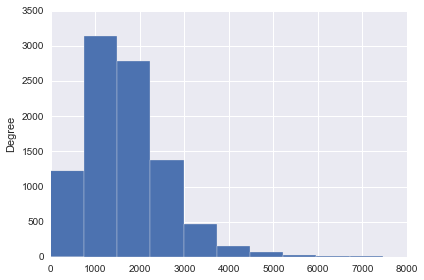

In [50]:
data.foodc.plot(kind='hist')

(array([ 1223.,  3138.,  2791.,  1384.,   461.,   157.,    67.,    23.,
           10.,     6.]),
 array([    0. ,   746.2,  1492.4,  2238.6,  2984.8,  3731. ,  4477.2,
         5223.4,  5969.6,  6715.8,  7462. ]),
 <a list of 10 Patch objects>)

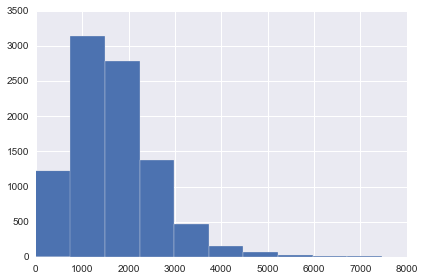

In [51]:
plt.hist(data.foodc.values)

You'll notice that the above graphs look really good!  This is because Seaborn has customized the styling.  You can also cusomize your `matplotlibrc` file to get your own style, but we'll talk abou that in a minute.

We can also specify the number of bins

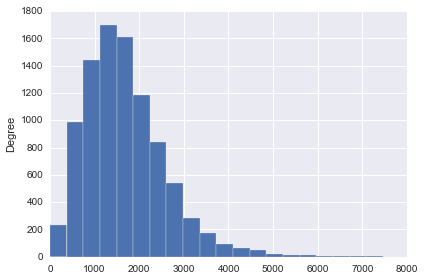

In [52]:
data.foodc.plot(kind='hist', bins=20)

Or we can change the styling, trying to plot multiple histograms simultaneously:

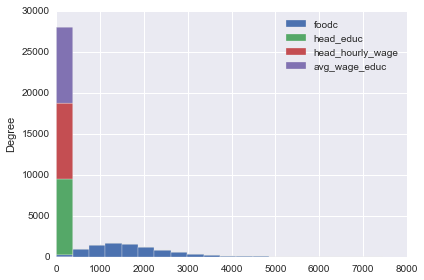

In [53]:
data.plot(kind='hist', stacked=True, bins=20)

But clearly that won't always work...

Setting aside style for now, we can use seaborn to produce some very fancy plots to visualize our data.  All seaborn does is give you a set of functions that produce the types of statistical plots that you might generally want.  It takes the hard work out of defining legends, smoothing, bins, etc.  Let's see some examples:

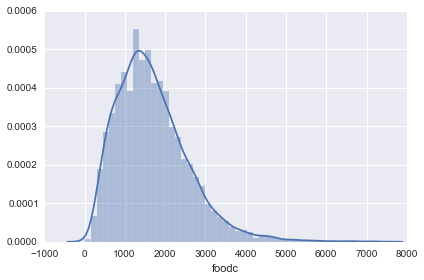

In [55]:
#Plotting a distribution over our histogram
sns.distplot(data.foodc)

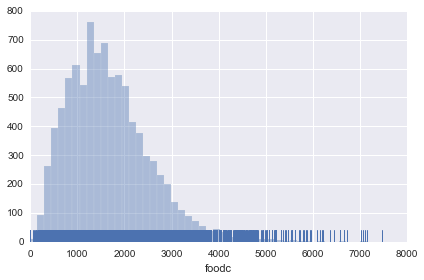

In [57]:
#Adding a 'rugplot' to the histogram
sns.distplot(data.foodc, kde=False, rug=True)

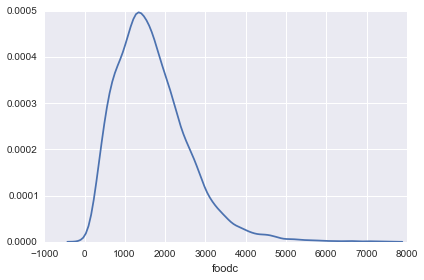

In [59]:
#Kernel density estimation
sns.distplot(data.foodc, hist=False)

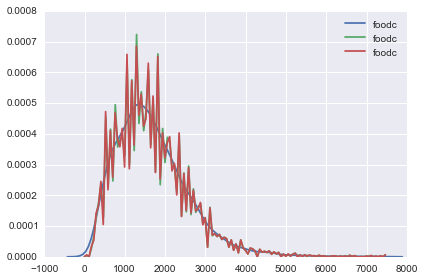

In [61]:
#Using kdeplot to do the same thing, but changing the bandwidth
sns.kdeplot(data.foodc)
sns.kdeplot(data.foodc, bw=0.2)
sns.kdeplot(data.foodc, bw=2)

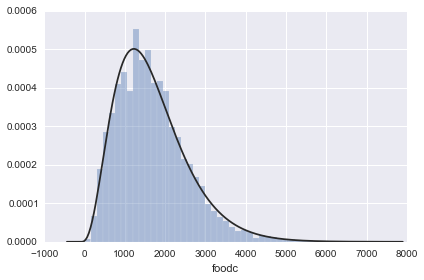

In [67]:
#Using distplot to fit a parametric distribution
sns.distplot(data.foodc, kde=False, fit=stats.gamma)

One of the coolest things (in my opinion) is how easy seaborn makes plotting bivariate distributions.

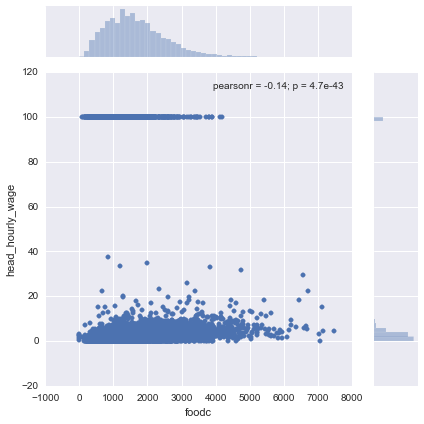

In [70]:
sns.jointplot(x = data.foodc, y = data.head_hourly_wage)

Noticing the outliers in the wage distribution, we can easily drop these from our plot:

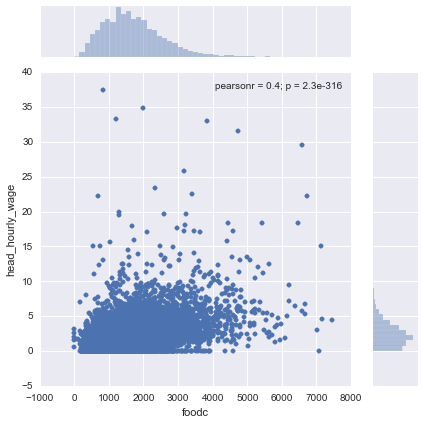

In [72]:
sns.jointplot(x = data.foodc[data.head_hourly_wage < 80],
              y = data.head_hourly_wage[data.head_hourly_wage < 80])

We can even exclude those with zero wage and zero food consumption by using multiple conditions:

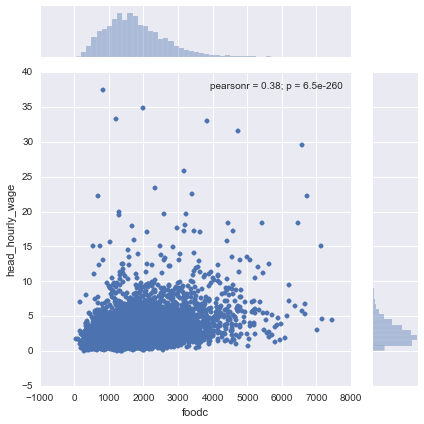

In [73]:
sns.jointplot(x = data.foodc[(data.head_hourly_wage < 80) &
                             (data.head_hourly_wage > 0) &
                             (data.foodc > 0)],
              y = data.head_hourly_wage[(data.head_hourly_wage < 80) &
                             (data.head_hourly_wage > 0) &
                             (data.foodc > 0)])

Still not cool enough?! What if I told you that seaborn would do multi-dimensional kernel density estimation for you?  Hmmmm?  That good enough?

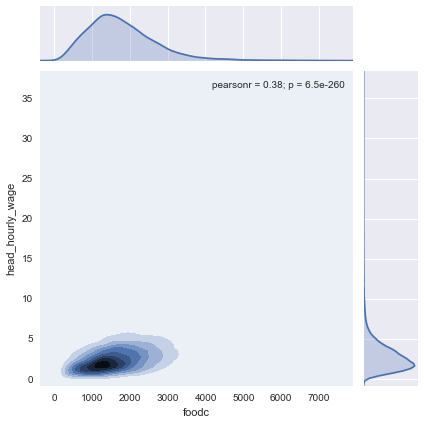

In [75]:
sns.jointplot(x = data.foodc[(data.head_hourly_wage < 80) &
                             (data.head_hourly_wage > 0) &
                             (data.foodc > 0)],
              y = data.head_hourly_wage[(data.head_hourly_wage < 80) &
                             (data.head_hourly_wage > 0) &
                             (data.foodc > 0)],
              kind = 'kde')

And if you'd like to visualize all of the pairwise relationships in your data, all you gotta do is ask:

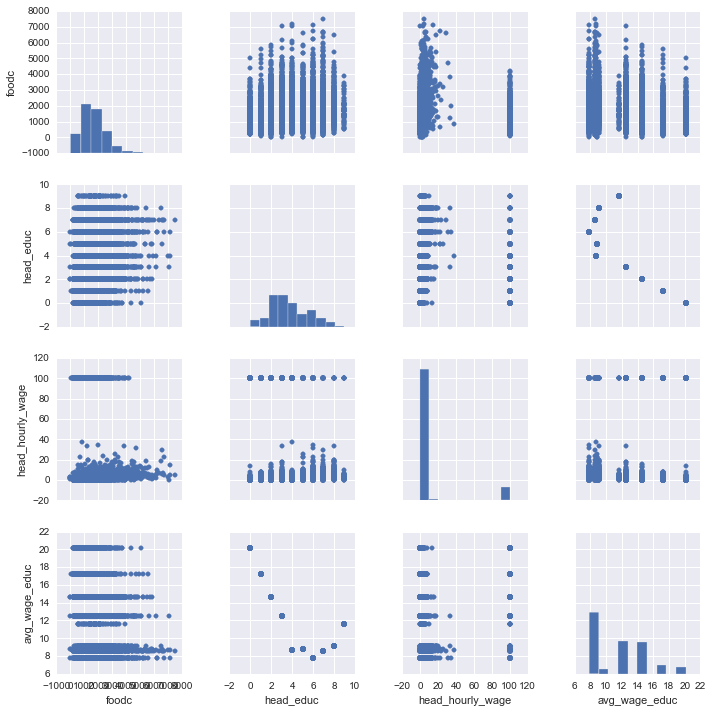

In [76]:
sns.pairplot(data)

Which, given the discrete nature of two of our variables, looks pretty silly, but saves you a lot of time and headache.

What if you're interested in plotting based on subgroups?  For instance, let's make our two dimensional scatter plot, but try to differentiate between education levels.  Seaborn offers a class just for this, called `FacetGrid`. 

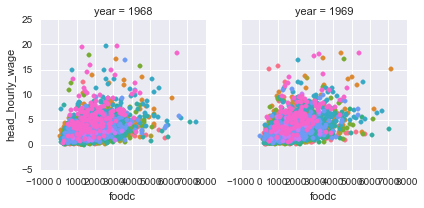

In [86]:
#First, let's generate a subset of data we are interested in
#NOTE: Here I'm resetting the index so I can use it more easily,
#I'm completely ignoring the fact that subsetting the data in
#this way drops observations... don't worry about it, just enjoy
#the pretty pictures.
subset = pd.DataFrame(data[(data.head_hourly_wage < 20) &
                           (data.head_hourly_wage > 0) &
                           (data.foodc > 0)].reset_index())

g = sns.FacetGrid(subset, col='year', hue='head_educ')
g.map(plt.scatter, 'foodc', 'head_hourly_wage')

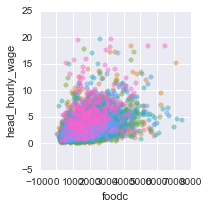

In [89]:
#We can also make the dots more transparent using the `alpha`
#argument, which is available for almost all plotting using
#matplotlib
#Here we'll pool all observations together
g = sns.FacetGrid(subset, hue='head_educ')
g.map(plt.scatter, 'foodc', 'head_hourly_wage', alpha = 0.5)

Using the `map` method you can make generally any kind of plot you'd like, even creating custom plot types.

Another type of plot you might find interesting is a `lmplot`, which is a linear regression plot.  It is used for plotting regressions over subsets of data, combining `regplot` and `FacetGrid`.

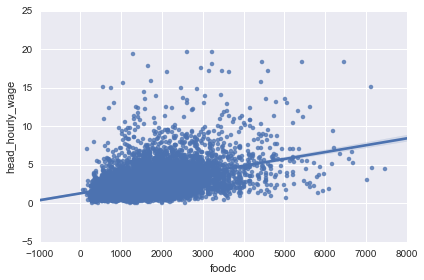

In [93]:
sns.regplot(x = subset.foodc, y = subset.head_hourly_wage)

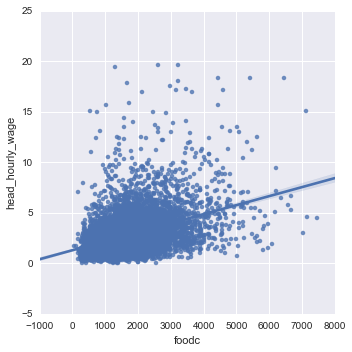

In [97]:
sns.lmplot(x = 'foodc', y = 'head_hourly_wage', data = subset)

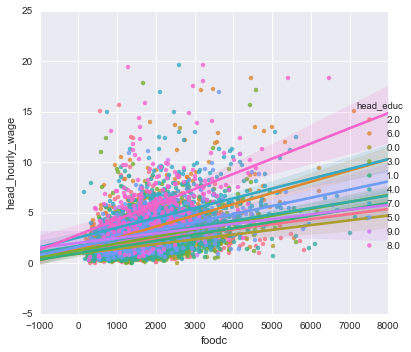

In [99]:
sns.lmplot(x = 'foodc', y = 'head_hourly_wage', hue='head_educ',
           data = subset)

Which is kind of messy, but you get the drift!  However, if you still want something clearer, you can plot each regression individually:

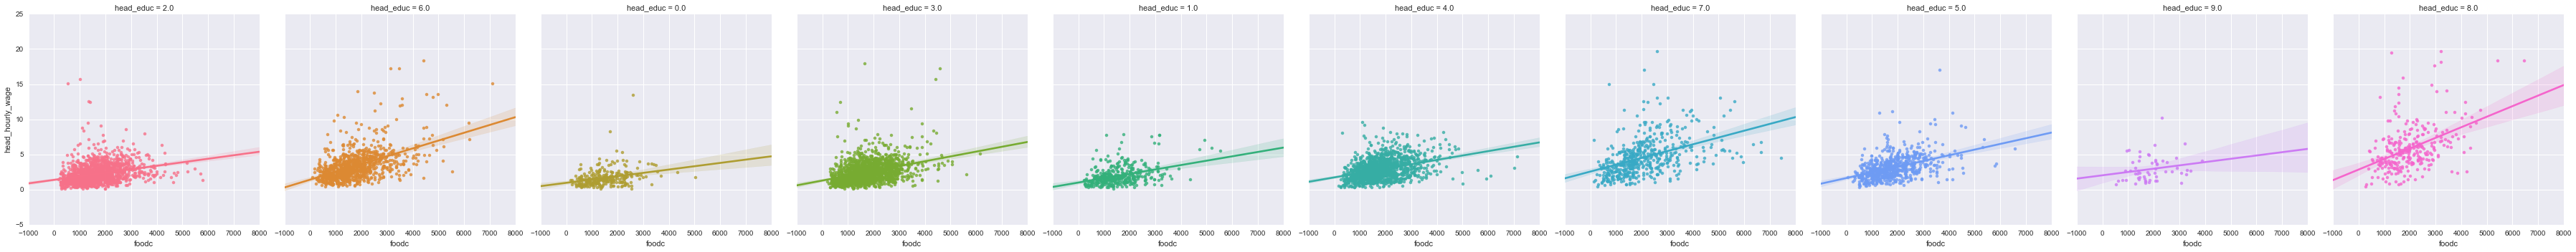

In [102]:
sns.lmplot(x = 'foodc', y = 'head_hourly_wage', col = 'head_educ',
           hue='head_educ', data = subset)

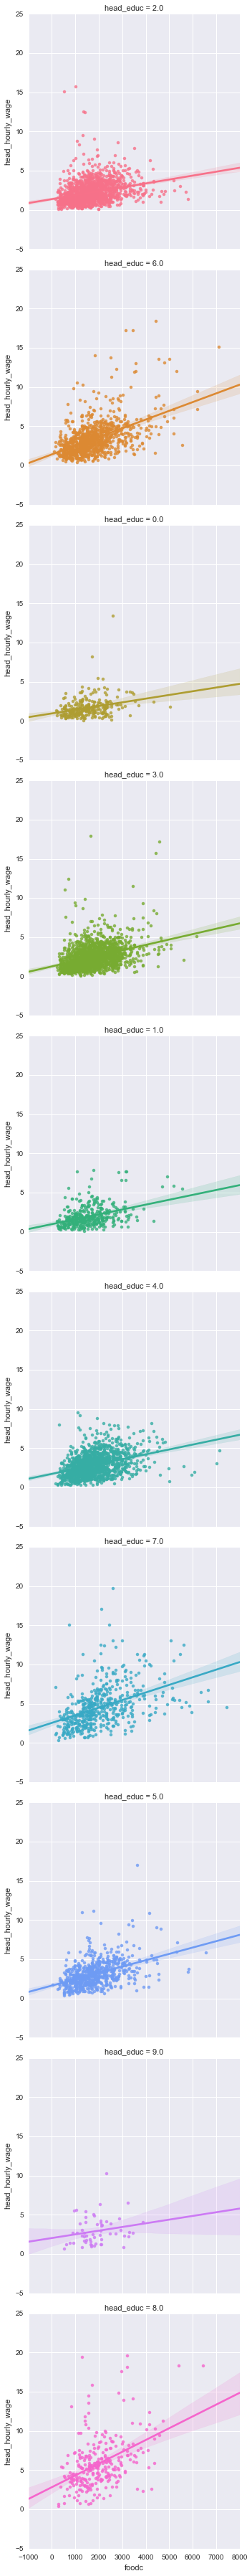

In [103]:
#... which is kind of small, so you could also do it as rows
sns.lmplot(x = 'foodc', y = 'head_hourly_wage', row = 'head_educ',
           hue='head_educ', data = subset)

### A Taste of Statistics Using StatsModels
Since we're probably running out of time, I just want to give one quick example using our data of doing some basic statistics using StatsModels.  Here is a really simple example just so you can see the output:

In [116]:
model = sm.OLS(subset.foodc, subset.head_hourly_wage)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  foodc   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                 1.789e+04
Date:                Tue, 20 Oct 2015   Prob (F-statistic):               0.00
Time:                        17:36:18   Log-Likelihood:                -63671.
No. Observations:                7570   AIC:                         1.273e+05
Df Residuals:                    7569   BIC:                         1.274e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
head_hourly_wage   476.6655      3.564  

And, since Pandas offers an easy way to generate dummies, we can even add dummies for `head_educ`:

In [117]:
X = pd.concat([subset.head_hourly_wage,
               pd.get_dummies(subset.head_educ)], axis = 1)
model = sm.OLS(subset.foodc, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  foodc   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     154.4
Date:                Tue, 20 Oct 2015   Prob (F-statistic):          6.05e-296
Time:                        17:36:32   Log-Likelihood:                -61520.
No. Observations:                7570   AIC:                         1.231e+05
Df Residuals:                    7559   BIC:                         1.231e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
head_hourly_wage   194.0325      5.292  

Sadly, we are running out of time, but StatsModels offers many other models to estimate.  These include the following, but the number is still growing:

* Linear regression
* General linear models
* Robust linear models
* Linear mixed effects models
* Discrete models
* Time series models
* Survival and duration models
* Nonparameteric methods
* GMM
* Empirical likelyhood

### Matplotlibrc

The last thing I'd like to mention is the `matplotlibrc` file.  This is loaded when you import matplotlib and sets the default parameters for your plots.  For instance, if you prefer to have a grid on your plots, you can set this automatically.

According to the matplotlib documentation, you should save the file in one of the following places:

* For linux: `~.config/matplotlib/matplotlibrc`
* For other: `.matplotlib/matplotlibrc`

You can also find the system file in one of the following places

* For linux: `/usr/lib/pythonX.X/site-packages/matplotlib/mpl-data/matplotlibrc`
* For windows: `C:\PythonXX\Lib\site-packages\matplotlib\mpl-data\matplotlibrc`

The system file can serve as a template for your own custom one, which should be saved in the former folder.  I'll paste here (well, ater this text) my own so you can see an example (it's quite long).

In this file you can set a plethora of tiny details that might interest you.  I encourage you to take a look and set your own, as it will help you to understand all that matplotlib can do.

##Conclusion

I hope that was a good enough introduction into the more advanced bits of Pandas and data analysis in Python.  I have left out everything about time series, which is admittedly one of Pandas strong suits, but I feel that most micro-economists use either panels or cross section and deal seldom with time series.  On that note, there is also a Panel data type in Pandas that could be quite useful, but that will be up to you to explore.

In [ ]:
### MATPLOTLIBRC FORMAT

# This is a sample matplotlib configuration file - you can find a copy
# of it on your system in
# site-packages/matplotlib/mpl-data/matplotlibrc.  If you edit it
# there, please note that it will be overwritten in your next install.
# If you want to keep a permanent local copy that will not be
# overwritten, place it in the following location:
# unix/linux:
#     $HOME/.config/matplotlib/matplotlibrc or
#     $XDG_CONFIG_HOME/matplotlib/matplotlibrc (if $XDG_CONFIG_HOME is set)
# other platforms:
#     $HOME/.matplotlib/matplotlibrc
#
# See http://matplotlib.org/users/customizing.html#the-matplotlibrc-file for
# more details on the paths which are checked for the configuration file.
#
# This file is best viewed in a editor which supports python mode
# syntax highlighting. Blank lines, or lines starting with a comment
# symbol, are ignored, as are trailing comments.  Other lines must
# have the format
#    key : val # optional comment
#
# Colors: for the color values below, you can either use - a
# matplotlib color string, such as r, k, or b - an rgb tuple, such as
# (1.0, 0.5, 0.0) - a hex string, such as ff00ff or #ff00ff - a scalar
# grayscale intensity such as 0.75 - a legal html color name, e.g., red,
# blue, darkslategray

#### CONFIGURATION BEGINS HERE

# The default backend; one of GTK GTKAgg GTKCairo GTK3Agg GTK3Cairo
# CocoaAgg MacOSX Qt4Agg Qt5Agg TkAgg WX WXAgg Agg Cairo GDK PS PDF SVG
# Template.
# You can also deploy your own backend outside of matplotlib by
# referring to the module name (which must be in the PYTHONPATH) as
# 'module://my_backend'.
backend      : qt4agg

# If you are using the Qt4Agg backend, you can choose here
# to use the PyQt4 bindings or the newer PySide bindings to
# the underlying Qt4 toolkit.
#backend.qt4 : PyQt4        # PyQt4 | PySide

# Note that this can be overridden by the environment variable
# QT_API used by Enthought Tool Suite (ETS); valid values are
# "pyqt" and "pyside".  The "pyqt" setting has the side effect of
# forcing the use of Version 2 API for QString and QVariant.

# The port to use for the web server in the WebAgg backend.
# webagg.port : 8888

# If webagg.port is unavailable, a number of other random ports will
# be tried until one that is available is found.
# webagg.port_retries : 50

# When True, open the webbrowser to the plot that is shown
# webagg.open_in_browser : True

# When True, the figures rendered in the nbagg backend are created with
# a transparent background.
# nbagg.transparent : True

# if you are running pyplot inside a GUI and your backend choice
# conflicts, we will automatically try to find a compatible one for
# you if backend_fallback is True
#backend_fallback: True

#interactive  : False
#toolbar      : toolbar2   # None | toolbar2  ("classic" is deprecated)
#timezone     : UTC        # a pytz timezone string, e.g., US/Central or Europe/Paris

# Where your matplotlib data lives if you installed to a non-default
# location.  This is where the matplotlib fonts, bitmaps, etc reside
#datapath : /home/jdhunter/mpldata

### LINES
# See http://matplotlib.org/api/artist_api.html#module-matplotlib.lines for more
# information on line properties.
lines.linewidth   : 2.0     # line width in points
#lines.linestyle   : -       # solid line
#lines.color       : blue    # has no affect on plot(); see axes.color_cycle
#lines.marker      : None    # the default marker
#lines.markeredgewidth  : 0.5     # the line width around the marker symbol
#lines.markersize  : 6            # markersize, in points
#lines.dash_joinstyle : miter        # miter|round|bevel
#lines.dash_capstyle : butt          # butt|round|projecting
#lines.solid_joinstyle : miter       # miter|round|bevel
#lines.solid_capstyle : projecting   # butt|round|projecting
lines.antialiased : True         # render lines in antialised (no jaggies)

### PATCHES
# Patches are graphical objects that fill 2D space, like polygons or
# circles.  See
# http://matplotlib.org/api/artist_api.html#module-matplotlib.patches
# information on patch properties
#patch.linewidth        : 1.0     # edge width in points
#patch.facecolor        : blue
#patch.edgecolor        : black
#patch.antialiased      : True    # render patches in antialised (no jaggies)
patch.linewidth        : 0.5     # edge width in points
patch.facecolor        : a6cee3
patch.edgecolor        : eeeeee
patch.antialiased      : True    # render patches in antialised (no jaggies)

### FONT
#
# font properties used by text.Text.  See
# http://matplotlib.org/api/font_manager_api.html for more
# information on font properties.  The 6 font properties used for font
# matching are given below with their default values.
#
# The font.family property has five values: 'serif' (e.g., Times),
# 'sans-serif' (e.g., Helvetica), 'cursive' (e.g., Zapf-Chancery),
# 'fantasy' (e.g., Western), and 'monospace' (e.g., Courier).  Each of
# these font families has a default list of font names in decreasing
# order of priority associated with them.  When text.usetex is False,
# font.family may also be one or more concrete font names.
#
# The font.style property has three values: normal (or roman), italic
# or oblique.  The oblique style will be used for italic, if it is not
# present.
#
# The font.variant property has two values: normal or small-caps.  For
# TrueType fonts, which are scalable fonts, small-caps is equivalent
# to using a font size of 'smaller', or about 83% of the current font
# size.
#
# The font.weight property has effectively 13 values: normal, bold,
# bolder, lighter, 100, 200, 300, ..., 900.  Normal is the same as
# 400, and bold is 700.  bolder and lighter are relative values with
# respect to the current weight.
#
# The font.stretch property has 11 values: ultra-condensed,
# extra-condensed, condensed, semi-condensed, normal, semi-expanded,
# expanded, extra-expanded, ultra-expanded, wider, and narrower.  This
# property is not currently implemented.
#
# The font.size property is the default font size for text, given in pts.
# 12pt is the standard value.
#
#font.family         : sans-serif
font.family         : serif
#font.style          : normal
#font.variant        : normal
font.weight         : 100
#font.stretch        : normal
# note that font.size controls default text sizes.  To configure
# special text sizes tick labels, axes, labels, title, etc, see the rc
# settings for axes and ticks. Special text sizes can be defined
# relative to font.size, using the following values: xx-small, x-small,
# small, medium, large, x-large, xx-large, larger, or smaller
font.size           : 12.0
font.serif          : Bitstream Vera Serif, New Century Schoolbook, Century Schoolbook L, Utopia, ITC Bookman, Bookman, Nimbus Roman No9 L, Times New Roman, Times, Palatino, Charter, serif
#font.sans-serif     : Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif
#font.cursive        : Apple Chancery, Textile, Zapf Chancery, Sand, cursive
#font.fantasy        : Comic Sans MS, Chicago, Charcoal, Impact, Western, fantasy
#font.monospace      : Bitstream Vera Sans Mono, Andale Mono, Nimbus Mono L, Courier New, Courier, Fixed, Terminal, monospace

### TEXT
# text properties used by text.Text.  See
# http://matplotlib.org/api/artist_api.html#module-matplotlib.text for more
# information on text properties

#text.color          : black
text.color          : 555555

### LaTeX customizations. See http://www.scipy.org/Wiki/Cookbook/Matplotlib/UsingTex
#text.usetex         : False  # use latex for all text handling. The following fonts
                              # are supported through the usual rc parameter settings:
                              # new century schoolbook, bookman, times, palatino,
                              # zapf chancery, charter, serif, sans-serif, helvetica,
                              # avant garde, courier, monospace, computer modern roman,
                              # computer modern sans serif, computer modern typewriter
                              # If another font is desired which can loaded using the
                              # LaTeX \usepackage command, please inquire at the
                              # matplotlib mailing list
#text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling
                            # unicode strings.
#text.latex.preamble :  # IMPROPER USE OF THIS FEATURE WILL LEAD TO LATEX FAILURES
                            # AND IS THEREFORE UNSUPPORTED. PLEASE DO NOT ASK FOR HELP
                            # IF THIS FEATURE DOES NOT DO WHAT YOU EXPECT IT TO.
                            # preamble is a comma separated list of LaTeX statements
                            # that are included in the LaTeX document preamble.
                            # An example:
                            # text.latex.preamble : \usepackage{bm},\usepackage{euler}
                            # The following packages are always loaded with usetex, so
                            # beware of package collisions: color, geometry, graphicx,
                            # type1cm, textcomp. Adobe Postscript (PSSNFS) font packages
                            # may also be loaded, depending on your font settings

#text.dvipnghack : None      # some versions of dvipng don't handle alpha
                             # channel properly.  Use True to correct
                             # and flush ~/.matplotlib/tex.cache
                             # before testing and False to force
                             # correction off.  None will try and
                             # guess based on your dvipng version

#text.hinting : auto   # May be one of the following:
                       #   'none': Perform no hinting
                       #   'auto': Use freetype's autohinter
                       #   'native': Use the hinting information in the
                       #             font file, if available, and if your
                       #             freetype library supports it
                       #   'either': Use the native hinting information,
                       #             or the autohinter if none is available.
                       # For backward compatibility, this value may also be
                       # True === 'auto' or False === 'none'.
#text.hinting_factor : 8 # Specifies the amount of softness for hinting in the
                         # horizontal direction.  A value of 1 will hint to full
                         # pixels.  A value of 2 will hint to half pixels etc.

#text.antialiased : True # If True (default), the text will be antialiased.
                         # This only affects the Agg backend.

# The following settings allow you to select the fonts in math mode.
# They map from a TeX font name to a fontconfig font pattern.
# These settings are only used if mathtext.fontset is 'custom'.
# Note that this "custom" mode is unsupported and may go away in the
# future.
#mathtext.cal : cursive
#mathtext.rm  : serif
#mathtext.tt  : monospace
#mathtext.it  : serif:italic
#mathtext.bf  : serif:bold
#mathtext.sf  : sans
#mathtext.fontset : cm # Should be 'cm' (Computer Modern), 'stix',
                       # 'stixsans' or 'custom'
#mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern
                                 # fonts when a symbol can not be found in one of
                                 # the custom math fonts.

#mathtext.default : it # The default font to use for math.
                       # Can be any of the LaTeX font names, including
                       # the special name "regular" for the same font
                       # used in regular text.

### AXES
# default face and edge color, default tick sizes,
# default fontsizes for ticklabels, and so on.  See
# http://matplotlib.org/api/axes_api.html#module-matplotlib.axes


image.cmap      :   coolwarm    #use this colormap for surface plotting... I hope!
#axes.hold           : True    # whether to clear the axes by default on
#axes.facecolor      : white   # axes background color
axes.facecolor      : eeeeee   # axes background color
#axes.edgecolor      : black   # axes edge color
#axes.edgecolor      : bcbcbc   # axes edge color
axes.edgecolor      : 555555   # axes edge color
axes.linewidth      : 1.0     # edge linewidth
#axes.grid           : False   # display grid or not
axes.titlesize      : x-large   # fontsize of the axes title
axes.labelsize      : large  # fontsize of the x any y labels
#axes.labelweight    : normal  # weight of the x and y labels
axes.labelcolor     : 555555
axes.axisbelow      : True   # whether axis gridlines and ticks are below
                               # the axes elements (lines, text, etc)

#axes.formatter.limits : -7, 7 # use scientific notation if log10
                               # of the axis range is smaller than the
                               # first or larger than the second
#axes.formatter.use_locale : False # When True, format tick labels
                                   # according to the user's locale.
                                   # For example, use ',' as a decimal
                                   # separator in the fr_FR locale.
#axes.formatter.use_mathtext : False # When True, use mathtext for scientific
                                     # notation.
#axes.formatter.useoffset      : True    # If True, the tick label formatter
                                         # will default to labeling ticks relative
                                         # to an offset when the data range is very
                                         # small compared to the minimum absolute
                                         # value of the data.

#axes.unicode_minus  : True    # use unicode for the minus symbol
                               # rather than hyphen.  See
                               # http://en.wikipedia.org/wiki/Plus_and_minus_signs#Character_codes
#axes.color_cycle    : b, g, r, c, m, y, k  # color cycle for plot lines
                                            # as list of string colorspecs:
                                            # single letter, long name, or
                                            # web-style hex
#axes.color_cycle    : 3b4cc0, 5d7ce6, 82a6fb, aac7fd, cdd9ec, ead4c8, f7b89c, f18d6f, d95847, b40426  # A colorcycle generated from the 'coolwarm' colormap using the commands C = [matplotlib.cm.get_cmap('coolwarm')(k) for k in linspace(0,1,10)]; [matplotlib.colors.rgb2hex(C[k]) for k in range(0,10)]    
#axes.color_cycle    : 1b9e77, ad6e1d, a36861, 9b58a5, da367f, 739929, bba90b, c8920e, 97722e, 666666    # " 'Dark2 colormap 
#axes.color_cycle    : 0b0000, 540000, 9e0000, ea0000, ff3400, ff8000, ffca00, ffff22, ffff91, ffffff    # " 'hot' colormap
#axes.color_cycle    : ff0000, ff4000, ff8000, ffc000, ffff00 # " 'autumn' colormap
#axes.color_cycle    :   000000, 4f3220, 9e6440, ed9660, ffc77f # " 'copper' colormap
#axes.color_cycle    : 333399, 01cc66, fefe98, 815e56, ffffff # " 'terrain' colormap
#axes.color_cycle    : 000000, 6701db, 9309dd, b52000, d04c00, e99500, ffff00 #'gnuplot' colormap
#axes.color_cycle    : 000000, 0000a8, 4200ff, c92ad5, ff7e81, ffd42b, ffffff # 'gnuplot2' colormap
#axes.color_cycle    : a6cee3, 1f78b4, b2df8a, 33a02c, fb9a99, e31a1c #custom from colorbrewer2.org NOTE: PREFERRED LIGHT COLORS
#axes.color_cycle    : e41a1c, 377eb8, 4daf4a, 984ea3, ff7f00, ffff33, a65628
#axes.color_cycle    : 3e3d4c, 114488, 551188, 2b2b2b, 1104fb, 111011, 8888aa #Custom from palletton.com
#axes.color_cycle    : e34848, 2b8888, 3ab53a, d46f1c, d41c1c, 117f7f, 16a916, 6b3100, 004040, 6b0000, 005600 #palleton
axes.color_cycle    : 005757, e34848, e38e48, 2b8888, 3ab53a, 000000 #palleton
#axes.color_cycle    : a6cee3, 1f78b4, b2df8a, 33a02c #custom. colorblind safe

#axes.xmargin        : 0  # x margin.  See `axes.Axes.margins`
#axes.ymargin        : 0  # y margin See `axes.Axes.margins`

#polaraxes.grid      : True    # display grid on polar axes
#axes3d.grid         : True    # display grid on 3d axes

### TICKS
# see http://matplotlib.org/api/axis_api.html#matplotlib.axis.Tick
#xtick.major.size     : 4      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.5    # major tick width in points
#xtick.minor.width    : 0.5    # minor tick width in points
#xtick.major.pad      : 4      # distance to major tick label in points
#xtick.minor.pad      : 4      # distance to the minor tick label in points
#xtick.color          : k      # color of the tick labels
#xtick.labelsize      : medium # fontsize of the tick labels
#xtick.direction      : in     # direction: in, out, or inout

xtick.major.size     : 4      # major tick size in points
xtick.minor.size     : 4      # minor tick size in points
#xtick.major.width    : 0.5    # major tick width in points
#xtick.minor.width    : 0.5    # minor tick width in points
xtick.major.pad      : 6      # distance to major tick label in points
xtick.minor.pad      : 6      # distance to the minor tick label in points
xtick.color          : 555555      # color of the tick labels
xtick.labelsize      : small # fontsize of the tick labels
xtick.direction      : in     # direction: in, out, or inout

#ytick.major.size     : 4      # major tick size in points
#ytick.minor.size     : 2      # minor tick size in points
#ytick.major.width    : 0.5    # major tick width in points
#ytick.minor.width    : 0.5    # minor tick width in points
#ytick.major.pad      : 4      # distance to major tick label in points
#ytick.minor.pad      : 4      # distance to the minor tick label in points
#ytick.color          : k      # color of the tick labels
#ytick.labelsize      : medium # fontsize of the tick labels
#ytick.direction      : in     # direction: in, out, or inout

ytick.major.size     : 4      # major tick size in points
ytick.minor.size     : 4      # minor tick size in points
#ytick.major.width    : 0.5    # major tick width in points
#ytick.minor.width    : 0.5    # minor tick width in points
ytick.major.pad      : 6      # distance to major tick label in points
ytick.minor.pad      : 6      # distance to the minor tick label in points
ytick.color          : 555555      # color of the tick labels
ytick.labelsize      : small # fontsize of the tick labels
ytick.direction      : in     # direction: in, out, or inout


### GRIDS
#grid.color       :   black   # grid color
#grid.linestyle   :   :       # dotted
#grid.linewidth   :   0.5     # in points
#grid.alpha       :   1.0     # transparency, between 0.0 and 1.0

### Legend
#legend.fancybox      : False  # if True, use a rounded box for the
                               # legend, else a rectangle
#legend.isaxes        : True
#legend.numpoints     : 2      # the number of points in the legend line
legend.fontsize      : small
#legend.borderpad     : 0.5    # border whitespace in fontsize units
#legend.markerscale   : 1.0    # the relative size of legend markers vs. original
# the following dimensions are in axes coords
#legend.labelspacing  : 0.5    # the vertical space between the legend entries in fraction of fontsize
#legend.handlelength  : 2.     # the length of the legend lines in fraction of fontsize
#legend.handleheight  : 0.7     # the height of the legend handle in fraction of fontsize
#legend.handletextpad : 0.8    # the space between the legend line and legend text in fraction of fontsize
#legend.borderaxespad : 0.5   # the border between the axes and legend edge in fraction of fontsize
#legend.columnspacing : 2.    # the border between the axes and legend edge in fraction of fontsize
#legend.shadow        : False
#legend.frameon       : True   # whether or not to draw a frame around legend
#legend.framealpha    : None    # opacity of of legend frame
#legend.scatterpoints : 3 # number of scatter points

### FIGURE
# See http://matplotlib.org/api/figure_api.html#matplotlib.figure.Figure
figure.figsize   : 10, 11    # figure size in inches
#figure.dpi       : 80      # figure dots per inch
#figure.facecolor : 0.75    # figure facecolor; 0.75 is scalar gray
figure.facecolor : 0.85    # figure facecolor; 0.75 is scalar gray
#figure.edgecolor : white   # figure edgecolor
figure.edgecolor : 0.5   # figure edgecolor
figure.autolayout : True  # When True, automatically adjust subplot
                            # parameters to make the plot fit the figure
#figure.max_open_warning : 20  # The maximum number of figures to open through
                               # the pyplot interface before emitting a warning.
                               # If less than one this feature is disabled.

# The figure subplot parameters.  All dimensions are a fraction of the
# figure width or height
#figure.subplot.left    : 0.125  # the left side of the subplots of the figure
#figure.subplot.right   : 0.9    # the right side of the subplots of the figure
#figure.subplot.bottom  : 0.1    # the bottom of the subplots of the figure
#figure.subplot.top     : 0.9    # the top of the subplots of the figure
#figure.subplot.wspace  : 0.2    # the amount of width reserved for blank space between subplots
figure.subplot.hspace  : 0.5    # the amount of height reserved for white space between subplots

### IMAGES
#image.aspect : equal             # equal | auto | a number
#image.interpolation  : bilinear  # see help(imshow) for options
#image.cmap   : jet               # gray | jet etc...
#image.lut    : 256               # the size of the colormap lookup table
#image.origin : upper             # lower | upper
#image.resample  : False

### CONTOUR PLOTS
#contour.negative_linestyle :  dashed # dashed | solid

### Agg rendering
### Warning: experimental, 2008/10/10
#agg.path.chunksize : 0           # 0 to disable; values in the range
                                  # 10000 to 100000 can improve speed slightly
                                  # and prevent an Agg rendering failure
                                  # when plotting very large data sets,
                                  # especially if they are very gappy.
                                  # It may cause minor artifacts, though.
                                  # A value of 20000 is probably a good
                                  # starting point.
### SAVING FIGURES
#path.simplify : True   # When True, simplify paths by removing "invisible"
                        # points to reduce file size and increase rendering
                        # speed
#path.simplify_threshold : 0.1  # The threshold of similarity below which
                                # vertices will be removed in the simplification
                                # process
#path.snap : True # When True, rectilinear axis-aligned paths will be snapped to
                  # the nearest pixel when certain criteria are met.  When False,
                  # paths will never be snapped.
#path.sketch : None # May be none, or a 3-tuple of the form (scale, length,
                    # randomness).
                    # *scale* is the amplitude of the wiggle
                    # perpendicular to the line (in pixels).  *length*
                    # is the length of the wiggle along the line (in
                    # pixels).  *randomness* is the factor by which
                    # the length is randomly scaled.

# the default savefig params can be different from the display params
# e.g., you may want a higher resolution, or to make the figure
# background white
#savefig.dpi         : 100      # figure dots per inch
#savefig.facecolor   : white    # figure facecolor when saving
#savefig.edgecolor   : white    # figure edgecolor when saving
#savefig.format      : png      # png, ps, pdf, svg
#savefig.bbox        : standard # 'tight' or 'standard'.
                                # 'tight' is incompatible with pipe-based animation
                                # backends but will workd with temporary file based ones:
                                # e.g. setting animation.writer to ffmpeg will not work,
                                # use ffmpeg_file instead
#savefig.pad_inches  : 0.1      # Padding to be used when bbox is set to 'tight'
#savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.
#savefig.directory   : ~        # default directory in savefig dialog box,
                                # leave empty to always use current working directory
#savefig.transparent : False    # setting that controls whether figures are saved with a
                                # transparent background by default

# tk backend params
#tk.window_focus   : False    # Maintain shell focus for TkAgg

# ps backend params
#ps.papersize      : letter   # auto, letter, legal, ledger, A0-A10, B0-B10
#ps.useafm         : False    # use of afm fonts, results in small files
#ps.usedistiller   : False    # can be: None, ghostscript or xpdf
                                          # Experimental: may produce smaller files.
                                          # xpdf intended for production of publication quality files,
                                          # but requires ghostscript, xpdf and ps2eps
#ps.distiller.res  : 6000      # dpi
#ps.fonttype       : 3         # Output Type 3 (Type3) or Type 42 (TrueType)

# pdf backend params
#pdf.compression   : 6 # integer from 0 to 9
                       # 0 disables compression (good for debugging)
#pdf.fonttype       : 3         # Output Type 3 (Type3) or Type 42 (TrueType)

# svg backend params
#svg.image_inline : True       # write raster image data directly into the svg file
#svg.image_noscale : False     # suppress scaling of raster data embedded in SVG
#svg.fonttype : 'path'         # How to handle SVG fonts:
#    'none': Assume fonts are installed on the machine where the SVG will be viewed.
#    'path': Embed characters as paths -- supported by most SVG renderers
#    'svgfont': Embed characters as SVG fonts -- supported only by Chrome,
#               Opera and Safari

# docstring params
#docstring.hardcopy = False  # set this when you want to generate hardcopy docstring

# Set the verbose flags.  This controls how much information
# matplotlib gives you at runtime and where it goes.  The verbosity
# levels are: silent, helpful, debug, debug-annoying.  Any level is
# inclusive of all the levels below it.  If your setting is "debug",
# you'll get all the debug and helpful messages.  When submitting
# problems to the mailing-list, please set verbose to "helpful" or "debug"
# and paste the output into your report.
#
# The "fileo" gives the destination for any calls to verbose.report.
# These objects can a filename, or a filehandle like sys.stdout.
#
# You can override the rc default verbosity from the command line by
# giving the flags --verbose-LEVEL where LEVEL is one of the legal
# levels, e.g., --verbose-helpful.
#
# You can access the verbose instance in your code
#   from matplotlib import verbose.
#verbose.level  : silent      # one of silent, helpful, debug, debug-annoying
#verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr

# Event keys to interact with figures/plots via keyboard.
# Customize these settings according to your needs.
# Leave the field(s) empty if you don't need a key-map. (i.e., fullscreen : '')

#keymap.fullscreen : f               # toggling
#keymap.home : h, r, home            # home or reset mnemonic
#keymap.back : left, c, backspace    # forward / backward keys to enable
#keymap.forward : right, v           #   left handed quick navigation
#keymap.pan : p                      # pan mnemonic
#keymap.zoom : o                     # zoom mnemonic
#keymap.save : s                     # saving current figure
#keymap.quit : ctrl+w, cmd+w         # close the current figure
#keymap.grid : g                     # switching on/off a grid in current axes
#keymap.yscale : l                   # toggle scaling of y-axes ('log'/'linear')
#keymap.xscale : L, k                # toggle scaling of x-axes ('log'/'linear')
#keymap.all_axes : a                 # enable all axes

# Control location of examples data files
#examples.directory : ''   # directory to look in for custom installation

###ANIMATION settings
#animation.writer : ffmpeg         # MovieWriter 'backend' to use
#animation.codec : mpeg4           # Codec to use for writing movie
#animation.bitrate: -1             # Controls size/quality tradeoff for movie.
                                   # -1 implies let utility auto-determine
#animation.frame_format: 'png'     # Controls frame format used by temp files
#animation.ffmpeg_path: 'ffmpeg'   # Path to ffmpeg binary. Without full path
                                   # $PATH is searched
#animation.ffmpeg_args: ''         # Additional arguments to pass to ffmpeg
#animation.avconv_path: 'avconv'   # Path to avconv binary. Without full path
                                   # $PATH is searched
#animation.avconv_args: ''         # Additional arguments to pass to avconv
#animation.mencoder_path: 'mencoder'
                                   # Path to mencoder binary. Without full path
                                   # $PATH is searched
#animation.mencoder_args: ''       # Additional arguments to pass to mencoder
#animation.convert_path: 'convert' # Path to ImageMagick's convert binary.
                                   # On Windows use the full path since convert
                                   # is also the name of a system tool.
